In [1]:
import matplotlib.pyplot as plt
#data manipulations
import numpy as np
import pandas as pd
#pytorch
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
from torchvision import transforms

#scraping from internet
from PIL import Image
#scraping from internet
import requests
from io import BytesIO
# time related
from timeit import default_timer as timer

In [2]:
IMAGE_SHAPE = (128, 128)

train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# datasets
trainset = torchvision.datasets.ImageFolder("../input/dataset/dataset/train", transform = train_transform)
validset = torchvision.datasets.ImageFolder("../input/dataset/dataset/val", transform = test_transform)
testset = torchvision.datasets.ImageFolder("../input/dataset/dataset/test", transform = test_transform)

#batches
batch_size = 16

# loaders for data
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

16


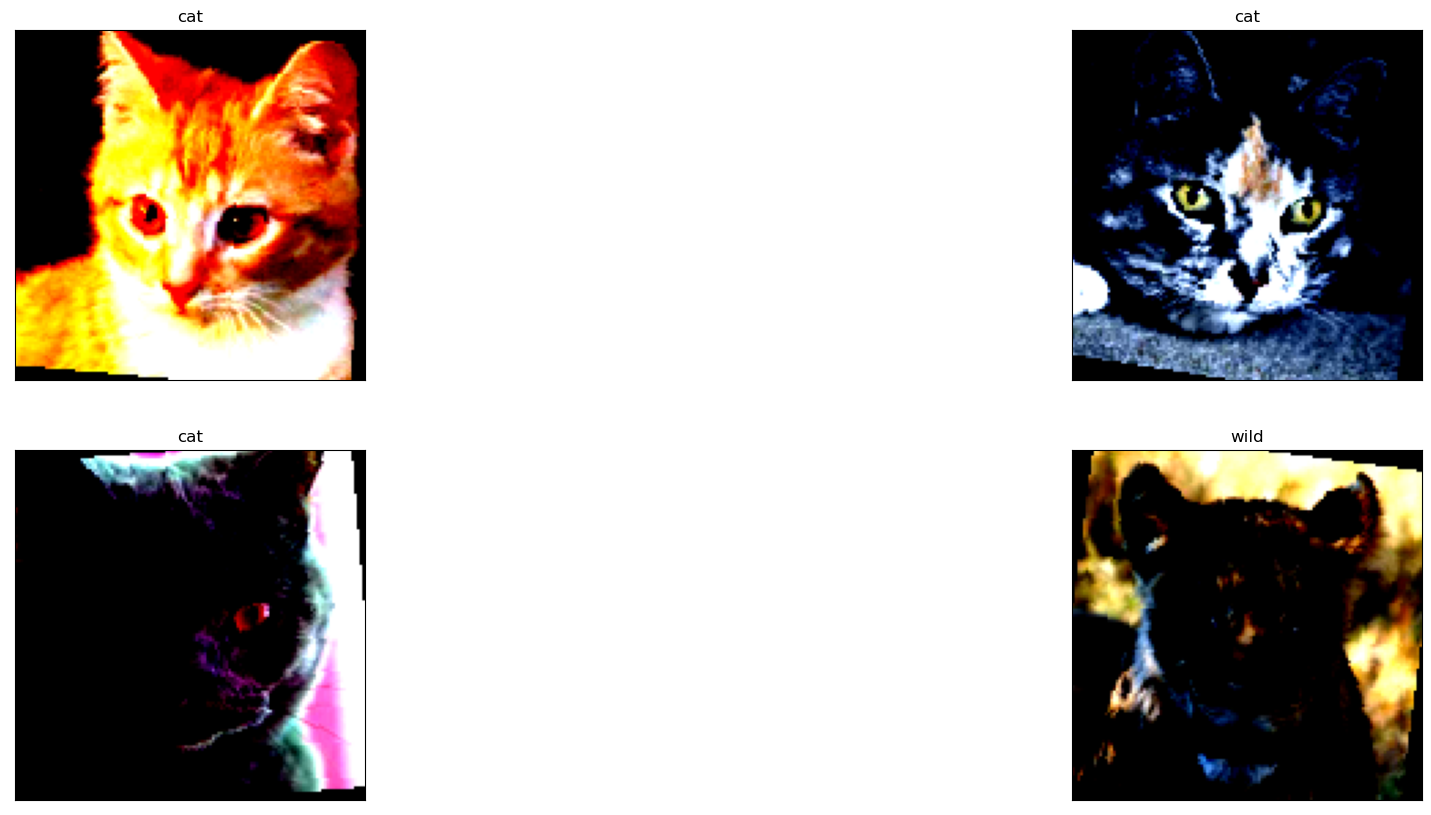

In [3]:
trainItr = iter(trainloader)
images, labels = next(trainItr)
print(len(images))
images, labels = images.numpy() , labels.numpy()


fig = plt.figure(figsize = (25,10))

for i in range(int(batch_size/4)):
    ax = fig.add_subplot(2 , int(batch_size/8) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i] , (1,2,0)))
    ax.set_title(trainset.classes[labels[i]])

In [4]:
print("Unique classes number : ",len(trainset.classes))
print("Classes : ", trainset.classes)

Unique classes number :  3
Classes :  ['cat', 'dog', 'wild']


In [5]:
my_gpu = torch.cuda.is_available()
device = torch.device('cuda' if my_gpu else 'cpu')
device

device(type='cuda')

In [7]:
model = torchvision.models.vgg11(num_classes=len(trainset.classes), weights=None)
model = model.to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [9]:
import csv
import os
from tqdm.auto import tqdm


open("/kaggle/working/training_logs-new.csv", "a", newline="")
log_file = open("/kaggle/working/training_logs-new.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])


def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == 'train':
        model.train()
    elif mode == 'val':
        model.eval()
  
    loss = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        loss += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    loss = loss/len(dataset)
    accuracy = correct/len(dataset)
    return loss, accuracy

num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_cost, train_score = loop_fn('train', trainset, trainloader, model, criterion, optimizer)
    with torch.no_grad():
        test_cost, test_score = loop_fn('val', validset, validloader, model, criterion, optimizer)
    print(epoch, float(train_cost), train_score, float(test_cost), test_score)
    csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])

Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

1 0.0007437016465701163 0.33844842284739984 0.008580404333770275 0.3507138423339541


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

2 0.000671573041472584 0.3379059133534837 0.008191442117094994 0.32464307883302296


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

3 0.0006784891593270004 0.3465085638998682 0.008122689090669155 0.3507138423339541


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

4 0.0006684217369183898 0.34340850964891884 0.007818183861672878 0.3507138423339541


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

5 0.0007107160054147243 0.3499961249321863 0.008322091773152351 0.3507138423339541


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

6 0.0007069353014230728 0.3448810354181198 0.008295767940580845 0.3507138423339541


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

7 0.0006882945308461785 0.340153452685422 0.008338995277881622 0.3507138423339541


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

8 0.000687922874931246 0.34317600558009764 0.008253560401499271 0.3507138423339541


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

9 0.0006621551583521068 0.3480585910253429 0.008357147686183453 0.3507138423339541


Train:   0%|          | 0/807 [00:00<?, ?it/s]

Val:   0%|          | 0/101 [00:00<?, ?it/s]

10 0.0007025881786830723 0.34449352863675115 0.008083812892436981 0.32464307883302296


In [6]:
torch.save(model.state_dict(), f"/kaggle/working/_e{epoch}.pth")

NameError: name 'model' is not defined

In [3]:
PRETRAINED_MODEL = "/kaggle/input/vgg-animal-faces/logs/_e10.pth"

In [4]:
from torchvision import models
import torch.nn.functional as F
from collections import OrderedDict
my_gpu = torch.cuda.is_available()
device = torch.device('cuda' if my_gpu else 'cpu')
device
model = models.vgg11(num_classes=3, weights=None)
model = model.to(device)
model.load_state_dict(torch.load(PRETRAINED_MODEL))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

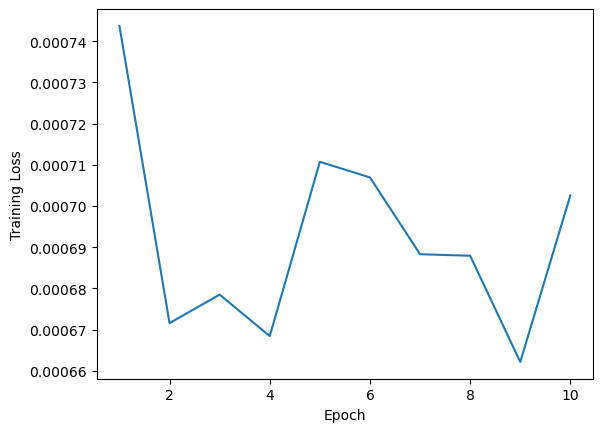

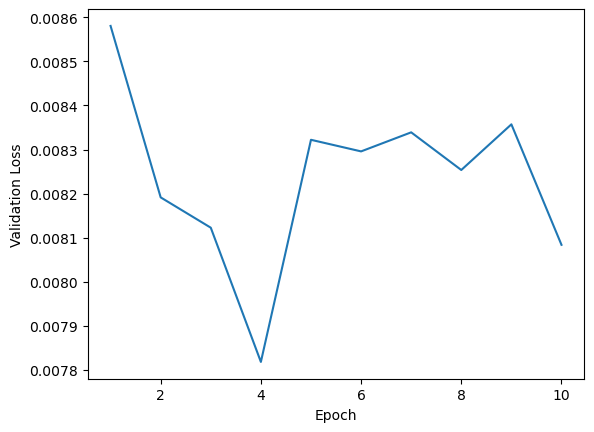

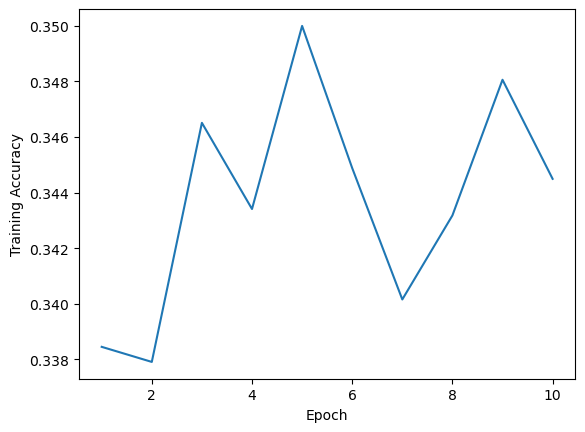

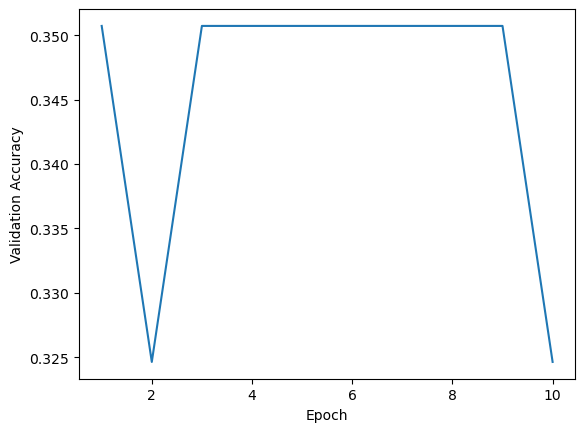

In [5]:
import pandas as pd

df = pd.read_csv("/kaggle/input/vgg-animal-faces/logs/training_logs.csv")

plt.figure("Epoch vs Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(df["epoch"], df["train_loss"])
plt.show()

plt.figure("Epoch vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.plot(df["epoch"], df["val_loss"])
plt.show()

plt.figure("Epoch vs Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.plot(df["epoch"], df["train_acc"])
plt.show()

plt.figure("Epoch vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(df["epoch"], df["val_acc"])
plt.show()

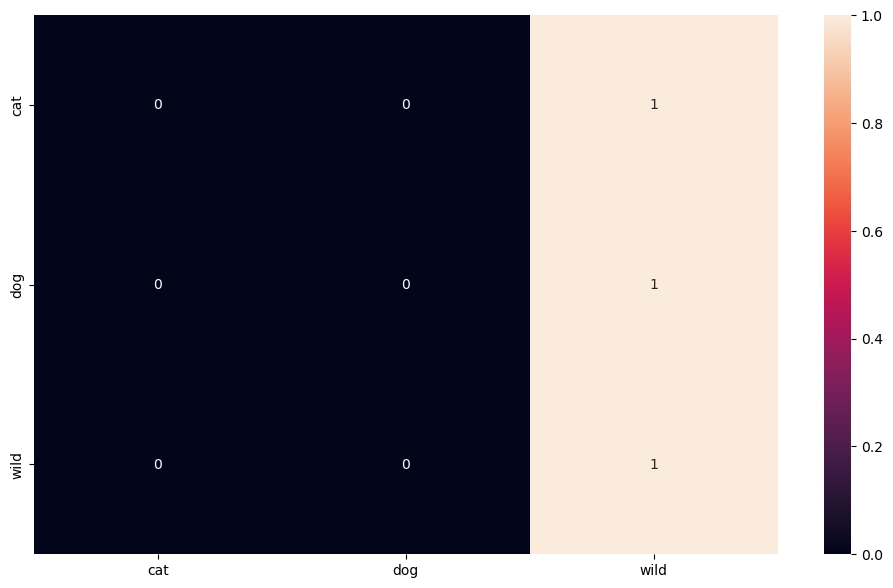

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = testset.classes
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')